# Arm Motion Modeling

## System Description

A double-pendulum system hanging in gravity is shown in the figure above. $q=[\theta_1, \theta_2]$ are the system configuration variables. We assume the z-axis is pointing out from the screen/paper, thus the positive direction of rotation is counter-clockwise.
The solution steps are:
1. Computing the Lagrangian of the system. 
2. Computing the Euler-Lagrange equations, and solve them for $\ddot{\theta}_1$ and $\ddot{\theta}_2$.
3. Numerically evaluating the solutions for ${\tau}_1$ and ${\tau}_2$, and simulating the system for ${\theta}_1$, ${\theta}_2$, $\dot{\theta}_1$, $\dot{\theta}_2$, $\ddot{\theta}_1$ and $\ddot{\theta}_2$.
4. Animating the simulation.

In [11]:
from IPython.core.display import HTML
display(HTML("<table><tr><td><img src='./double-pendulum-diagram.png' width=450' height='300'></table>"))

## Import Libraries and Define System Constants

Import libraries:

In [12]:
# Imports required for data processing
import os
import csv
import pandas as pd

# Imports required for dynamics calculations
import sympy
from sympy.abc import t
from sympy import symbols, Eq, Function, solve, sin, cos, Matrix, Subs, substitution, Derivative, simplify, symbols, lambdify
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Imports required for animation
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
import plotly.graph_objects as go

Define the system's constants:

In [13]:
# Masses, length and center-of-mass positions (calculated using the lab measurements)
# Mass calculations (mass unit is kg) 
m_body = 53
m_upper_arm = 0.028 * m_body             # Average upper arm weights relative to body weight, from “Biomechanics
                                         # and Motor Control of Human Movement” by David Winter (2009), 4th edition
m_lower_arm = 0.7395                     # Average lower prosthetics weights, calculated using lab measurements  
# m_lower_arm = 0.022 * m_body           # Average lower arm weights relative to body weight, from “Biomechanics
                                         # and Motor Control of Human Movement” by David Winter (2009), 4th edition
# Arm length calculations (length unit is m) 
H_body = 1.62
L_upper_arm = 0.186 * H_body             # Average upper arm length relative to body height
                                         # from “Biomechanics and Motor Control of Human Movement” by David
                                         # Winter (2009), 4th edition
# L_lower_arm = (0.146 + 0.108) * H_body   # Average lower arm length relative to body height
                                         # from “Biomechanics and Motor Control of Human Movement” by David
                                         # Winter (2009), 4th edition
L_lower_arm = 0.42                       # Average lower prosthetics length, calculated using lab measurements 

# Arm center of mass length calculations (length unit is m) 
L_upper_arm_COM = 0.436 * L_upper_arm    # Average upper arm length from shoulder to center of mass relative
                                         # to upper arm length, from “Biomechanics and Motor Control of Human
                                         # Movement” by David Winter (2009), 4th edition
L_lower_arm_COM = 0.2388                 # Average lower prosthetics length from elbow to center of mass,
                                         # calculated using lab measurements 
# L_lower_arm_COM = 0.682 * L_lower_arm  # Average lower prosthetics length from elbow to center of mass,

## Extracting Data

Extracting angles data and computing angular velocities and angular accelerations from the angles:

In [55]:
def calculate_Vel(Ang_list, time_list, index):
    return ((Ang_list[index + 1] - Ang_list[index])
          / (time_list[index + 1] - time_list[index]))


def calculate_Acc(Vel_list, time_list, index):
    return ((Vel_list[index + 1] - Vel_list[index])
          / (time_list[index + 1] - time_list[index]))


data_csv_dir = '../../data/hand_back_motion_data/CSV Converted Files'
frame_frequency = 100
print("current directory: ", os.getcwd())

walking_vel_list = []
time_list = []
Elbow_Ang_list, Sholder_Ang_list = [], []
Elbow_Vel_list, Sholder_Vel_list = [], []
Elbow_Acc_list, Sholder_Acc_list = [], []
Elbow_Acc_data_list, Sholder_Acc_data_list = [], []
Back_Ang_list, Back_Pos_list, Back_Vel_list = [], [], []

folder_list = os.listdir(data_csv_dir)
folder_list.sort()

for folder in folder_list:

    data_trial_dir = os.path.join(data_csv_dir, folder)
    if os.path.isdir(data_trial_dir):
        file_list = os.listdir(data_trial_dir)

        for file in file_list:
            if "00B429F8" in file:
                if file.endswith(".csv"):
                    file_name = file[:-4]
                    walking_vel = file.split("_")[4][:5]

                    frame = 0
                    file_time_list = []
                    file_Sholder_Ang_list, file_Sholder_Vel_list, file_Sholder_Acc_list, file_Sholder_Acc_data_list = [], [], [], []

                    # Cutting out weird data behavior on data edges
                    data_path = os.path.join(data_csv_dir, folder, file)
                    data_rows = open(data_path).read().strip().split("\n")[7500:9500]

                    # Extract time [sec], elbow angles [rad], and shoulder angles [rad] from data
                    for row in data_rows:
                        splitted_row = row.strip().split("\t")

                        # Check if loop finished all data
                        if not len(splitted_row):
                            break

                        file_time_list.append(frame / frame_frequency)
                        file_Sholder_Ang_list.append(float(splitted_row[31]) * 2*pi/360)
                        file_Sholder_Acc_data_list.append(float(splitted_row[14]))
                        frame += 1

                    # Extract elbow and shoulder velocities [rad/sec] from angles
                    for i in range(len(file_time_list) - 1):
                        Sholder_Vel = calculate_Vel(file_Sholder_Ang_list, file_time_list, i)
                        file_Sholder_Vel_list.append(Sholder_Vel)

                    # Extract elbow and shoulder Accelerations [rad/sec^2] from velocities
                    for i in range(len(file_time_list) - 2):
                        Sholder_Acc = calculate_Acc(file_Sholder_Vel_list, file_time_list, i)
                        file_Sholder_Acc_list.append(Sholder_Acc)

                    # Adjust lists length
                    adjusted_file_time_list = file_time_list[:-2]
                    adjusted_file_Sholder_Ang_list = file_Sholder_Ang_list[:-2]
                    adjusted_file_Sholder_Vel_list = file_Sholder_Vel_list[:-1]
                    adjusted_file_Sholder_Acc_data_list = file_Sholder_Acc_data_list[:-2]

                    time_list.append(adjusted_file_time_list)
                    walking_vel_list.append(walking_vel)

                    Sholder_Ang_list.append(adjusted_file_Sholder_Ang_list)
                    Sholder_Vel_list.append(adjusted_file_Sholder_Vel_list)
                    Sholder_Acc_list.append(file_Sholder_Acc_list)
                    Sholder_Acc_data_list.append(adjusted_file_Sholder_Acc_data_list)
                    break

        for file in file_list:
            if "00B429E2" in file:
                if file.endswith(".csv"):
                    file_name = file[:-4]
                    walking_vel = file.split("_")[4][:5]

                    frame = 0
                    file_time_list = []
                    file_Elbow_Ang_list, file_Elbow_Vel_list, file_Elbow_Acc_list, file_Elbow_Acc_data_list = [], [], [], []

                    # Cutting out weird data behavior on data edges
                    data_path = os.path.join(data_csv_dir, folder, file)
                    data_rows = open(data_path).read().strip().split("\n")[7500:9500]

                    # Extract time [sec], elbow angles [rad], and shoulder angles [rad] from data
                    for i in range(len(data_rows)):
                        splitted_row = data_rows[i].strip().split("\t")

                        # Check if loop finished all data
                        if not len(splitted_row):
                            break

                        file_time_list.append(frame / frame_frequency)
                        file_Elbow_Ang_list.append((float(splitted_row[31]) - file_Sholder_Ang_list[i]) * 2*pi/360)
                        file_Elbow_Acc_data_list.append(float(splitted_row[14]))
                        frame += 1

                    # Extract elbow and shoulder velocities [rad/sec] from angles
                    for i in range(len(file_time_list) - 1):
                        Elbow_Vel = calculate_Vel(file_Elbow_Ang_list, file_time_list, i)
                        file_Elbow_Vel_list.append(Elbow_Vel)

                    # Extract elbow and shoulder Accelerations [rad/sec^2] from velocities
                    for i in range(len(file_time_list) - 2):
                        Elbow_Acc = calculate_Acc(file_Elbow_Vel_list, file_time_list, i)
                        file_Elbow_Acc_list.append(Elbow_Acc)

                    # Adjust lists length
                    adjusted_file_Elbow_Ang_list = file_Elbow_Ang_list[:-2]
                    adjusted_file_Elbow_Vel_list = file_Elbow_Vel_list[:-1]
                    adjusted_file_Elbow_Acc_data_list = file_Elbow_Acc_data_list[:-2]

                    Elbow_Ang_list.append(adjusted_file_Elbow_Ang_list)
                    Elbow_Vel_list.append(adjusted_file_Elbow_Vel_list)
                    Elbow_Acc_list.append(file_Elbow_Acc_list)
                    Elbow_Acc_data_list.append(file_Elbow_Acc_data_list)
                    break

        for file in file_list:
            if "00B43D0C" in file:
                if file.endswith(".csv"):
                    file_name = file[:-4]
                    walking_vel = file.split("_")[4][:5]
                    if walking_vel == "1.4ms":
                        continue

                    frame = 0
                    file_time_list = []
                    file_Back_Ang_list, file_Back_Pos_list, file_Back_Vel_list = [], [], []

                    # Cutting out weird data behavior on data edges
                    data_path = os.path.join(data_csv_dir, folder, file)
                    data_rows = open(data_path).read().strip().split("\n")[7500:9500]

                    # Extract time [sec], elbow angles [rad], and shoulder angles [rad] from data
                    for i in range(len(data_rows)):
                        splitted_row = data_rows[i].strip().split("\t")

                        # Check if loop finished all data
                        if not len(splitted_row):
                            break

                        file_time_list.append(frame / frame_frequency)
                        
                        file_Back_Ang_list.append(float(splitted_row[31]) * 2*pi/360)
                        file_Back_Pos_list.append(float(splitted_row[21]))
                        file_Back_Vel_list.append(float(splitted_row[24]))
                        frame += 1

                    # Adjust lists length
                    adjusted_file_Back_Ang_list = file_Back_Ang_list[:-2]
                    adjusted_file_Back_Pos_list = file_Back_Pos_list[:-2]
                    adjusted_file_Back_Vel_list = file_Back_Vel_list[:-2]

                    Back_Ang_list.append(adjusted_file_Back_Ang_list)
                    Back_Pos_list.append(adjusted_file_Back_Pos_list)
                    Back_Vel_list.append(adjusted_file_Back_Vel_list)
                    break

current directory:  /home/yael/Documents/MSR_Courses/ME499-Final_Project/Motorized-Prosthetic-Arm/motor_control/arm_pendulum_modeling


## System Modeling

Computing the Lagrangian of the system:

In [19]:
m1, m2, g, R1, R1_COM, R2, R2_COM = symbols(r'm1, m2, g, R1, R1_COM, R2, R2_COM')

# The system torque variables as function of t
tau1 = Function(r'tau1')(t)
tau2 = Function(r'tau2')(t)

# The system configuration variables as function of t
theta1 = Function(r'theta1')(t)
theta2 = Function(r'theta2')(t)

# The velocity as derivative of position wrt t
theta1_dot = theta1.diff(t)
theta2_dot = theta2.diff(t)

# The acceleration as derivative of velocity wrt t
theta1_ddot = theta1_dot.diff(t)
theta2_ddot = theta2_dot.diff(t)

# Converting the polar coordinates to cartesian coordinates
x1 = R1_COM * sin(theta1)
x2 = R1 * sin(theta1) + R2_COM * sin(theta1 + theta2)

y1 = -R1_COM * cos(theta1)
y2 = -R1 * cos(theta1) - R2_COM * cos(theta1 + theta2)

# Calculating the kinetic and potential energy of the system
KE = 1/2 * m1 * ((x1.diff(t))**2 + (y1.diff(t))**2) + 1/2 * m2 * ((x2.diff(t))**2 + (y2.diff(t))**2)
PE = m1 * g * y1 + m2 * g * y2

# Computing the Lagrangian
L = simplify(KE - PE)
Lagrange = Function(r'L')(t)
display(Eq(Lagrange, L))

Eq(L(t), 0.5*R1_COM**2*m1*Derivative(theta1(t), t)**2 + R1_COM*g*m1*cos(theta1(t)) + g*m2*(R1*cos(theta1(t)) + R2_COM*cos(theta1(t) + theta2(t))) + 0.5*m2*(R1**2*Derivative(theta1(t), t)**2 + 2*R1*R2_COM*cos(theta2(t))*Derivative(theta1(t), t)**2 + 2*R1*R2_COM*cos(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) + R2_COM**2*Derivative(theta1(t), t)**2 + 2*R2_COM**2*Derivative(theta1(t), t)*Derivative(theta2(t), t) + R2_COM**2*Derivative(theta2(t), t)**2))

Computing the Euler-Lagrange equations:

In [20]:
# Define the derivative of L wrt the functions: x, xdot
L_dtheta1 = L.diff(theta1)
L_dtheta2 = L.diff(theta2)

L_dtheta1_dot = L.diff(theta1_dot)
L_dtheta2_dot = L.diff(theta2_dot)

# Define the derivative of L_dxdot wrt to time t
L_dtheta1_dot_dt = L_dtheta1_dot.diff(t)
L_dtheta2_dot_dt = L_dtheta2_dot.diff(t)

# Define the left hand side of the the Euler-Lagrange as a matrix
lhs = Matrix([simplify(L_dtheta1_dot_dt - L_dtheta1),
              simplify(L_dtheta2_dot_dt - L_dtheta2)])

# Define the right hand side of the the Euler-Lagrange as a Matrix
rhs = Matrix([tau1, tau2])

# Compute the Euler-Lagrange equations as a matrix
EL_eqns = Eq(lhs, rhs)

print('Euler-Lagrange matrix for this systems:')
display(EL_eqns)

Euler-Lagrange matrix for this systems:


Eq(Matrix([
[1.0*R1_COM**2*m1*Derivative(theta1(t), (t, 2)) + R1_COM*g*m1*sin(theta1(t)) + g*m2*(R1*sin(theta1(t)) + R2_COM*sin(theta1(t) + theta2(t))) + m2*(R1**2*Derivative(theta1(t), (t, 2)) - 2*R1*R2_COM*sin(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) - R1*R2_COM*sin(theta2(t))*Derivative(theta2(t), t)**2 + 2*R1*R2_COM*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R1*R2_COM*cos(theta2(t))*Derivative(theta2(t), (t, 2)) + R2_COM**2*Derivative(theta1(t), (t, 2)) + R2_COM**2*Derivative(theta2(t), (t, 2)))],
[                                                                                                                                                                                                                                                                                                           R2_COM*m2*(R1*sin(theta2(t))*Derivative(theta1(t), t)**2 + R1*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R2_COM*Derivative(theta1(t), (t, 2)) + R2_COM*Derivative(the

Solve the equations for ${\tau}_1$ and ${\tau}_2$:

In [21]:
# Solve the Euler-Lagrange equations for the shoulder and elbow torques
T = Matrix([tau1, tau2])
soln = solve(EL_eqns, T, dict=True)

# Initialize the solutions
solution = [0, 0]
i = 0

for sol in soln:
    for v in T:
        solution[i] = simplify(sol[v])
        display(Eq(T[i], solution[i]))
        i =+ 1

Eq(tau1(t), R1**2*m2*Derivative(theta1(t), (t, 2)) - 2.0*R1*R2_COM*m2*sin(theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) - R1*R2_COM*m2*sin(theta2(t))*Derivative(theta2(t), t)**2 + 2.0*R1*R2_COM*m2*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R1*R2_COM*m2*cos(theta2(t))*Derivative(theta2(t), (t, 2)) + R1*g*m2*sin(theta1(t)) + R1_COM**2*m1*Derivative(theta1(t), (t, 2)) + R1_COM*g*m1*sin(theta1(t)) + R2_COM**2*m2*Derivative(theta1(t), (t, 2)) + R2_COM**2*m2*Derivative(theta2(t), (t, 2)) + R2_COM*g*m2*sin(theta1(t) + theta2(t)))

Eq(tau2(t), R2_COM*m2*(R1*sin(theta2(t))*Derivative(theta1(t), t)**2 + R1*cos(theta2(t))*Derivative(theta1(t), (t, 2)) + R2_COM*Derivative(theta1(t), (t, 2)) + R2_COM*Derivative(theta2(t), (t, 2)) + g*sin(theta1(t) + theta2(t))))

Simulating the system:

In [22]:
# Substitute the derivative variables with a dummy variables and plug-in the constants
solution_0_subs = solution[0]
solution_1_subs = solution[1]

theta1_dot_dummy = symbols('thetadot1')
theta2_dot_dummy = symbols('thetadot2')
theta1_ddot_dummy = symbols('thetaddot1')
theta2_ddot_dummy = symbols('thetaddot2')

solution_0_subs = solution_0_subs.subs([(g, 9.81)])
solution_1_subs = solution_1_subs.subs([(g, 9.81)])

solution_0_subs = solution_0_subs.subs([((theta1.diff(t)).diff(t), theta1_ddot_dummy),
                                        ((theta2.diff(t)).diff(t), theta2_ddot_dummy)])
solution_1_subs = solution_1_subs.subs([((theta1.diff(t)).diff(t), theta1_ddot_dummy),
                                        ((theta2.diff(t)).diff(t), theta2_ddot_dummy)])

solution_0_subs = solution_0_subs.subs([(theta1.diff(t), theta1_dot_dummy),
                                        (theta2.diff(t), theta2_dot_dummy)])
solution_1_subs = solution_1_subs.subs([(theta1.diff(t), theta1_dot_dummy),
                                        (theta2.diff(t), theta2_dot_dummy)])

# Lambdify the thetas and its derivatives
func1 = lambdify([theta1, theta2, theta1_dot_dummy, theta2_dot_dummy, theta1_ddot_dummy,
                  theta2_ddot_dummy, m1, m2, R1, R2, R1_COM, R2_COM], solution_0_subs, modules = sympy)
func2 = lambdify([theta1, theta2, theta1_dot_dummy, theta2_dot_dummy, theta1_ddot_dummy,
                  theta2_ddot_dummy, m1, m2, R1, R2, R1_COM, R2_COM], solution_1_subs, modules = sympy)

# Initialize the torque and power lists
Sholder_tau_list, Elbow_tau_list = [], []
Sholder_current_list, Elbow_current_list = [], []
Sholder_power_list, Elbow_power_list = [], []

motor_kv = 115
torque_const = 8.27 / motor_kv

for i in range(len(time_list)):
    # Initialize the torque and power lists
    tau1_list, tau2_list = [], []
    current1_list, current2_list = [], []
    power1_list, power2_list = [], []

    t_list = time_list[i]
    theta1_list = Sholder_Ang_list[i]
    theta2_list = Elbow_Ang_list[i]
    dtheta1_list = Sholder_Vel_list[i]
    dtheta2_list = Elbow_Vel_list[i]
    ddtheta1_list = Sholder_Acc_list[i]
    ddtheta2_list = Elbow_Acc_list[i]

    # Plug-in the angles, angular velocities and angular accelerations for every time step to find the torques
    for j in range(len(t_list)):
        tau1_list.append(func1(theta1_list[j], theta2_list[j], dtheta1_list[j], dtheta2_list[j],
                               ddtheta1_list[j], ddtheta2_list[j], m_upper_arm, m_lower_arm,
                               L_upper_arm, L_lower_arm, L_upper_arm_COM, L_lower_arm_COM))
        
        tau2_list.append(func2(theta1_list[j], theta2_list[j], dtheta1_list[j], dtheta2_list[j],
                               ddtheta1_list[j], ddtheta2_list[j], m_upper_arm, m_lower_arm,
                               L_upper_arm, L_lower_arm, L_upper_arm_COM, L_lower_arm_COM))

        # Calculate the current required to reach the required joints torques for every time step
        current1_list.append(torque_const * tau1_list[j])
        current2_list.append(torque_const * tau2_list[j])

        # Calculate the power required to reach the required angular velocities and joints torques for every time step
        power1_list.append(dtheta1_list[j] * tau1_list[j])
        power2_list.append(dtheta2_list[j] * tau2_list[j])

    Sholder_tau_list.append(tau1_list)
    Elbow_tau_list.append(tau2_list)
    Sholder_current_list.append(current1_list)
    Elbow_current_list.append(current2_list)
    Sholder_power_list.append(power1_list)
    Elbow_power_list.append(power2_list)

    print(f"Velocity {walking_vel_list[i]}\t max torque: {format(max(tau2_list), '.3f')}[Nm]\t max angular velocity: {format(max(dtheta2_list), '.3f')}[rad/sec]\t max power: {format(max(power2_list), '.3f')}[W]")

Velocity 0.5ms	 max torque: 0.228[Nm]	 max angular velocity: 1.625[rad/sec]	 max power: 1.693[W]
Velocity 0.6ms	 max torque: 0.332[Nm]	 max angular velocity: 1.731[rad/sec]	 max power: 1.798[W]
Velocity 0.7ms	 max torque: 0.552[Nm]	 max angular velocity: 2.556[rad/sec]	 max power: 2.379[W]
Velocity 0.8ms	 max torque: 0.900[Nm]	 max angular velocity: 3.695[rad/sec]	 max power: 4.734[W]
Velocity 0.9ms	 max torque: 1.497[Nm]	 max angular velocity: 3.370[rad/sec]	 max power: 4.650[W]
Velocity 1.0ms	 max torque: 3.806[Nm]	 max angular velocity: 3.588[rad/sec]	 max power: 12.103[W]
Velocity 1.1ms	 max torque: 1.901[Nm]	 max angular velocity: 2.989[rad/sec]	 max power: 3.543[W]
Velocity 1.2ms	 max torque: 2.264[Nm]	 max angular velocity: 3.567[rad/sec]	 max power: 3.809[W]
Velocity 1.3ms	 max torque: 3.269[Nm]	 max angular velocity: 4.525[rad/sec]	 max power: 5.310[W]
Velocity 1.4ms	 max torque: 4.890[Nm]	 max angular velocity: 4.931[rad/sec]	 max power: 8.735[W]
Velocity chang	 max torque: 2

Calculation summary:

In [58]:
max_Elbow_tau, max_Elbow_power, max_Elbow_Vel = 0, 0, 0
max_Elbow_tau_index, max_Elbow_power_index, max_Elbow_Vel_index = 0, 0, 0

for i in range(len(Elbow_tau_list)):
    if max_Elbow_Vel < max(Elbow_Vel_list[i]):
        max_Elbow_Vel = max(Elbow_Vel_list[i])
        max_Elbow_Vel_index = i
        
    if max_Elbow_tau < max(Elbow_tau_list[i]):
        max_Elbow_tau = max(Elbow_tau_list[i])
        max_Elbow_tau_index = i
        
    if max_Elbow_power < max(Elbow_power_list[i]):
        max_Elbow_power = max(Elbow_power_list[i])
        max_Elbow_power_index = i

print(f"maximum elbow angular velocity is {format(max_Elbow_Vel, '.3f')} [rad/sec] ({format(max_Elbow_Vel*60/(2*pi), '.3f')} [rpm]), in velocity {walking_vel_list[max_Elbow_Vel_index]} (trial {max_Elbow_Vel_index})")
print(f"maximum elbow torque is {format(max_Elbow_tau, '.3f')} [Nm], in velocity {walking_vel_list[max_Elbow_tau_index]} (trial {max_Elbow_tau_index})")
print(f"maximum elbow power is {format(max_Elbow_power, '.3f')} [W], in velocity {walking_vel_list[max_Elbow_power_index]} (trial {max_Elbow_power_index})")


# The torque equations for the maximum power:
solution_0_subs = solution_0_subs.subs([(m1, m_upper_arm), (m2, m_lower_arm), (R1, L_upper_arm), (R2, L_lower_arm), (R1_COM, L_upper_arm_COM), (R2_COM, L_lower_arm_COM), (g, 9.81)])
solution_1_subs = solution_1_subs.subs([(m1, m_upper_arm), (m2, m_lower_arm), (R1, L_upper_arm), (R2, L_lower_arm), (R1_COM, L_upper_arm_COM), (R2_COM, L_lower_arm_COM), (g, 9.81)])

print("\nThe torque equations for the maximum torque:")
display(Eq(T[0], solution_0_subs))
display(Eq(T[1], solution_1_subs))

# display(Elbow_Ang_list[max_Elbow_tau_index])
# display(Elbow_Vel_list[max_Elbow_tau_index])
# display(Elbow_Acc_list[max_Elbow_tau_index])
# display(Elbow_tau_list[max_Elbow_tau_index])
# display(Elbow_Ang_list[2])
# display(Elbow_tau_list[2])

maximum elbow angular velocity is 4.931 [rad/sec] (47.091 [rpm]), in velocity 1.4ms (trial 9)
maximum elbow torque is 4.890 [Nm], in velocity 1.4ms (trial 9)
maximum elbow power is 12.103 [W], in velocity 1.0ms (trial 5)

The torque equations for the maximum torque:


Eq(tau1(t), 0.106421764464*thetaddot1*cos(theta2(t)) + 0.134925423831621*thetaddot1 + 0.053210882232*thetaddot2*cos(theta2(t)) + 0.04217031288*thetaddot2 - 0.106421764464*thetadot1*thetadot2*sin(theta2(t)) - 0.053210882232*thetadot2**2*sin(theta2(t)) + 1.732373406*sin(theta1(t) + theta2(t)) + 4.0984945085808*sin(theta1(t)))

Eq(tau2(t), 0.053210882232*thetaddot1*cos(theta2(t)) + 0.04217031288*thetaddot1 + 0.04217031288*thetaddot2 + 0.053210882232*thetadot1**2*sin(theta2(t)) + 1.732373406*sin(theta1(t) + theta2(t)))

Example for the trial with the largest elbow torque & power:

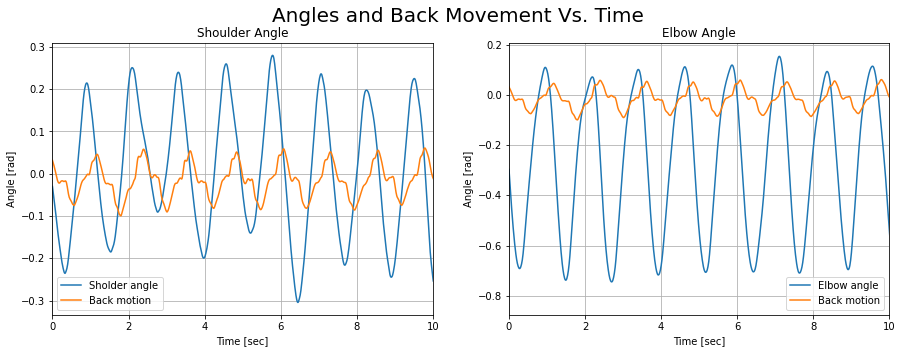

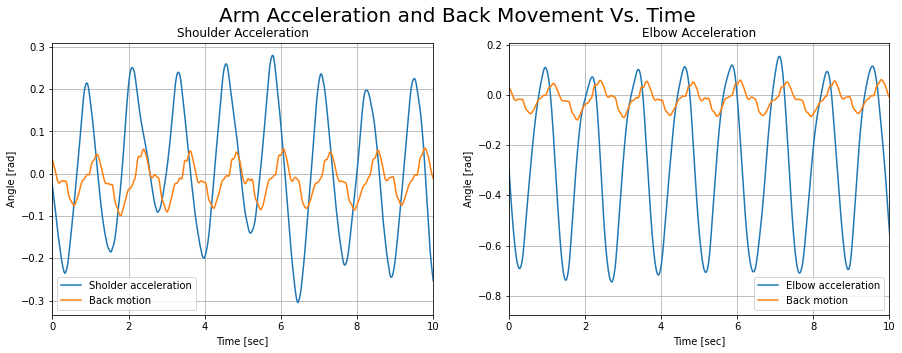

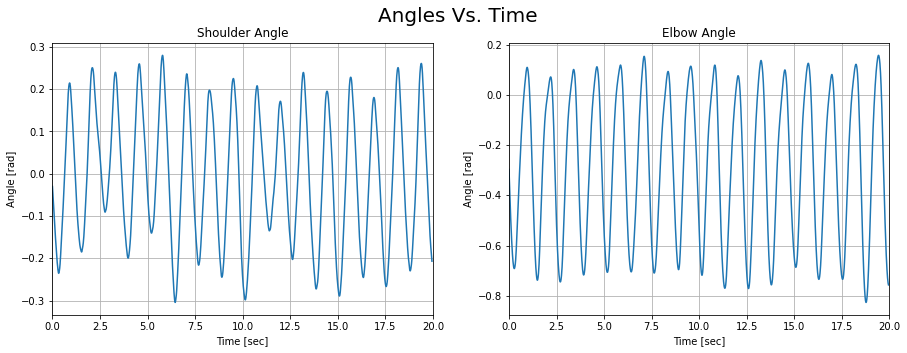

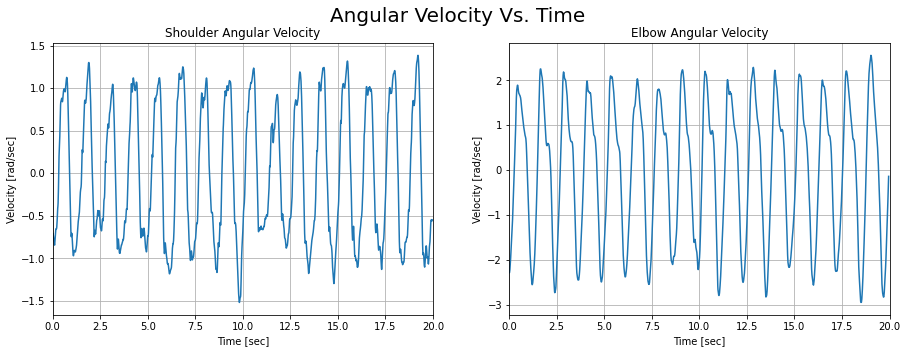

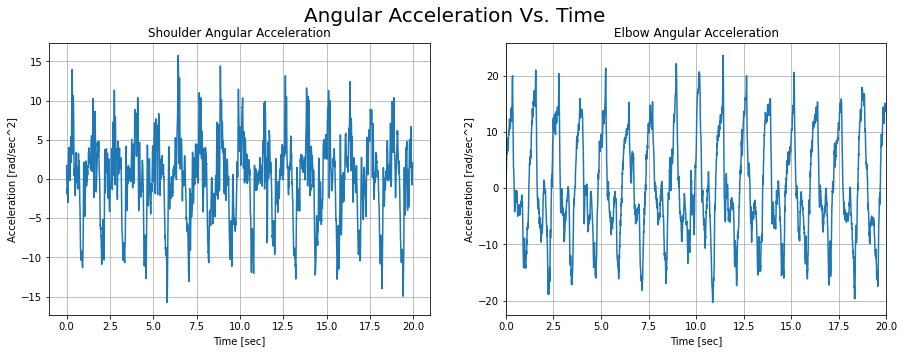

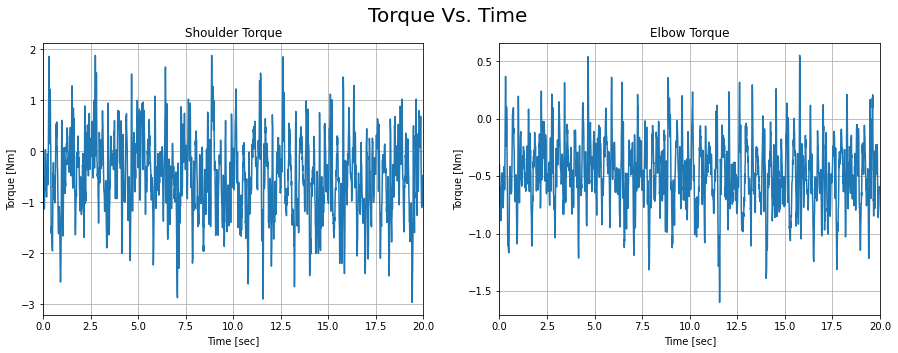

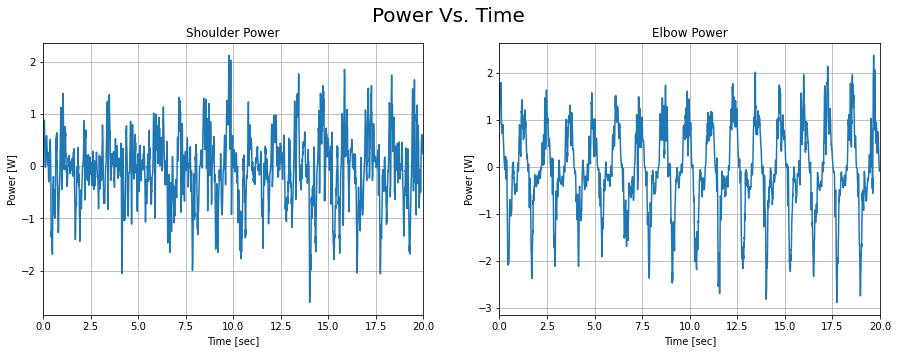

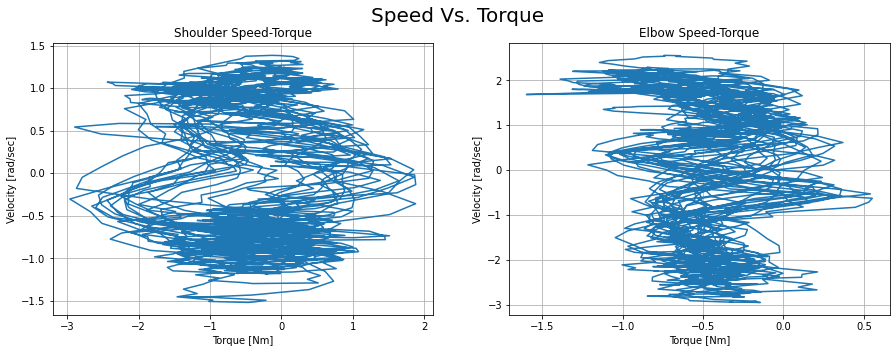

In [61]:
index = 2
t_list = time_list[index]
theta1_list = Sholder_Ang_list[index]
theta2_list = Elbow_Ang_list[index]
dtheta1_list = Sholder_Vel_list[index]
dtheta2_list = Elbow_Vel_list[index]
ddtheta1_list = Sholder_Acc_list[index]
ddtheta2_list = Elbow_Acc_list[index]
tau1_list = Sholder_tau_list[index]
tau2_list = Elbow_tau_list[index]
current1_list = Sholder_current_list[index]
current2_list = Elbow_current_list[index]
power1_list = Sholder_power_list[index]
power2_list = Elbow_power_list[index]

back_rotation_list = Back_Ang_list[index]
back_position_list = Back_Pos_list[index]
back_velocity_list = Back_Vel_list[index]

Elbow_Acceleration_list = Elbow_Acc_data_list[index]
Sholder_Acceleration_list = Sholder_Acc_data_list[index]

# Compute the trajectory of the arm's motion
N = int((max(t_list) - min(t_list))/(1/frame_frequency))
tvec = np.linspace(min(t_list), max(t_list), N)
traj = np.zeros((6, N))
back_traj = np.zeros((3, N))
acc_traj = np.zeros((2, N))
partial_traj = np.zeros((6, N))

for i in range(N):
    traj[0, i] = theta1_list[i]
    traj[1, i] = theta2_list[i]
    traj[2, i] = dtheta1_list[i]
    traj[3, i] = dtheta2_list[i]
    traj[4, i] = ddtheta1_list[i]
    traj[5, i] = ddtheta2_list[i]

    
    back_traj[0, i] = back_rotation_list[i]
    back_traj[1, i] = back_position_list[i]
    back_traj[2, i] = back_velocity_list[i]

    acc_traj[0, i] = Elbow_Acceleration_list[i]
    acc_traj[1, i] = Sholder_Acceleration_list[i]

for i in range(100):
    partial_traj[0, i] = theta1_list[i]
    partial_traj[1, i] = theta2_list[i]
    partial_traj[2, i] = dtheta1_list[i]
    partial_traj[3, i] = dtheta2_list[i]
    partial_traj[4, i] = ddtheta1_list[i]
    partial_traj[5, i] = ddtheta2_list[i]

# Calculate the length difference between the time list and the trajectory lists
diff = (len(t_list) - len(traj[0]))

# Plot the trajectory lists (angles, velocities, accelerations, torques, and power)
plt.figure(figsize=(15,5))
plt.suptitle('Angles and Back Movement Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list[:-diff], traj[0], label="Sholder angle")
plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
plt.ylabel('Angle [rad]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec)/2)])
plt.grid()
plt.legend()
plt.title('Shoulder Angle')

plt.subplot(122)
plt.plot(t_list[:-diff], traj[1], label="Elbow angle")
plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
plt.ylabel('Angle [rad]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec)/2)])
plt.grid()
plt.legend()
plt.title('Elbow Angle')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Arm Acceleration and Back Movement Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list[:-diff], traj[0], label="Sholder acceleration")
plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
plt.ylabel('Angle [rad]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec)/2)])
plt.grid()
plt.legend()
plt.title('Shoulder Acceleration')

plt.subplot(122)
plt.plot(t_list[:-diff], traj[1], label="Elbow acceleration")
plt.plot(t_list[:-diff], back_traj[0], label="Back motion")
plt.ylabel('Angle [rad]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec)/2)])
plt.grid()
plt.legend()
plt.title('Elbow Acceleration')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Angles Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list[:-diff], traj[0])
plt.ylabel('Angle [rad]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Shoulder Angle')

plt.subplot(122)
plt.plot(t_list[:-diff], traj[1])
plt.ylabel('Angle [rad]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Elbow Angle')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Angular Velocity Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list[:-diff], traj[2])
plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Shoulder Angular Velocity')

plt.subplot(122)
plt.plot(t_list[:-diff], traj[3])
plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Elbow Angular Velocity')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Angular Acceleration Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list[:-diff], traj[4])
plt.ylabel('Acceleration [rad/sec^2]')
plt.xlabel('Time [sec]')
plt.grid()
plt.title('Shoulder Angular Acceleration')

plt.subplot(122)
plt.plot(t_list[:-diff], traj[5])
plt.ylabel('Acceleration [rad/sec^2]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Elbow Angular Acceleration')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Torque Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list, tau1_list)
plt.ylabel('Torque [Nm]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Shoulder Torque')

plt.subplot(122)
plt.plot(t_list, tau2_list)
plt.ylabel('Torque [Nm]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Elbow Torque')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Power Vs. Time', fontsize=20)
plt.subplot(121)
plt.plot(t_list, power1_list)
plt.ylabel('Power [W]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Shoulder Power')

plt.subplot(122)
plt.plot(t_list, power2_list)
plt.ylabel('Power [W]')
plt.xlabel('Time [sec]')
plt.xlim([0, math.ceil(max(tvec))])
plt.grid()
plt.title('Elbow Power')
plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('Speed Vs. Torque', fontsize=20)
plt.subplot(121)
plt.plot(tau1_list[:-diff], traj[2])
plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Torque [Nm]')
plt.grid()
plt.title('Shoulder Speed-Torque')

plt.subplot(122)
plt.plot(tau2_list[:-diff], traj[3])
plt.ylabel('Velocity [rad/sec]')
plt.xlabel('Torque [Nm]')
plt.grid()
plt.title('Elbow Speed-Torque')
plt.show()

Animating the simulation:

In [62]:
def animate_double_pend(traj, L1, L2, L1_COM, L2_COM, T):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
        traj:        trajectory of theta1 and theta2
        L1:          length of the upper arm
        L2:          length of the lower arm 
        L1_COM:      length of the center of mass of the upper arm from the shoulder 
        L2_COM:      length of the center of mass of the lower arm from the elbow
        T:           length/seconds of animation duration
        
    Returns: None
    """

    # Browser configuration
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    # Getting data from pendulum angle trajectories
    xx1 = L1 * np.sin(traj[0])
    yy1 = -L1 * np.cos(traj[0])
    xx1_COM = L1_COM * np.sin(traj[0])
    yy1_COM = -L1_COM * np.cos(traj[0])
    xx2 = xx1 + L2 * np.sin(traj[0] + traj[1])
    yy2 = yy1 - L2 * np.cos(traj[0] + traj[1])
    xx2_COM = xx1 + L2_COM * np.sin(traj[0] + traj[1])
    yy2_COM = yy1 - L2_COM * np.cos(traj[0] + traj[1])
    N = len(traj[0])

    # Using these to specify axis limits
    xm = np.min(xx1)
    xM = np.max(xx1)
    ym = np.min(yy1) - 0.6
    yM = np.max(yy1) + 0.6

    # Defining data dictionary
    data = [dict(x=xx1, y=yy1, 
                 mode='lines', name='Arm', 
                 line=dict(width=5, color='blue')
                ),
            dict(x=xx1_COM, y=yy1_COM, 
                 mode='lines', name='Upper Arm Center of Mass',
                 line=dict(width=2, color='green')
                ),
            dict(x=xx2_COM, y=yy2_COM, 
                 mode='lines', name='Lower Arm Center of Mass',
                 line=dict(width=2, color='orange')
                ),
            dict(x=xx1, y=yy1, 
                 mode='markers', name='Elbow Trajectory', 
                 marker=dict(color="green", size=2)
                ),
            dict(x=xx2, y=yy2, 
                 mode='markers', name='Hand Trajectory', 
                 marker=dict(color="orange", size=2)
                )
          ]

    # Preparing simulation layout
    layout = dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                  yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                  title='Simulation of Arm Modeled as a Double Pendulum', 
                  hovermode='closest',
                  updatemenus= [{'type': 'buttons',
                                 'buttons': [{'label': 'Play', 'method': 'animate',
                                              'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                             {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                              'transition': {'duration': 0}}],'label': 'Pause', 'method': 'animate'}
                                            ]
                                }]
                 )

    # Defining the frames of the simulation
    frames = [dict(data=[dict(x=[0,xx1[k],xx2[k]], 
                              y=[0,yy1[k],yy2[k]], 
                              mode='lines',
                              line=dict(color='red', width=4)),
                         go.Scatter(
                              x=[xx1_COM[k]],
                              y=[yy1_COM[k]],
                              mode="markers",
                              marker=dict(color="blue", size=12)),
                         go.Scatter(
                              x=[xx2_COM[k]],
                              y=[yy2_COM[k]],
                              mode="markers",
                              marker=dict(color="purple", size=12)),
                        ]) for k in range(N)]

    # Putting it all together and plotting
    figure = dict(data=data, layout=layout, frames=frames)           
    iplot(figure)

# Animate the system
L1 = L_upper_arm
L2 = L_lower_arm
L1_COM = L_upper_arm_COM
L2_COM = L_lower_arm_COM
T = 5

animate_double_pend(partial_traj, L1, L2, L1_COM, L2_COM, T)